In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/dblp-scholar-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/dblp-scholar-reduced/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = [],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine', 'inverse_l1'],
                        text_compositions=['average', 'idf', 'bi_lstm'],
                        numeric_sim_metrics=[],
                        dense_nodes=[32, 16],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False,
                        lstm_args=dict(units=25, dropout=0, recurrent_dropout=0),
                        batch_norm=True,
                        dropout=0.5)

Number of inputs to dense layer: 99


# Crash recovery 

In [4]:
model.load_weights('../data/models/dblp-scholar-base-2-allcomp-allsim')
df_hist = pd.read_csv('../data/histories/dblp-scholar-base-2-allcomp-allsim.csv')

histories['acc'] = list(df_hist['acc'].values)
histories['val_acc'] = list(df_hist['val_acc'].values)
histories['loss'] = list(df_hist['loss'].values)
histories['val_loss'] = list(df_hist['val_loss'].values)

# Train model 

In [45]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=8192,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 432038 samples, validate on 54004 samples
Epoch 1/1
432038/432038 [==============================] - 151s 348us/step - loss: 0.0019 - acc: 0.9997 - val_loss: 0.0031 - val_acc: 0.9996


# Learning curves

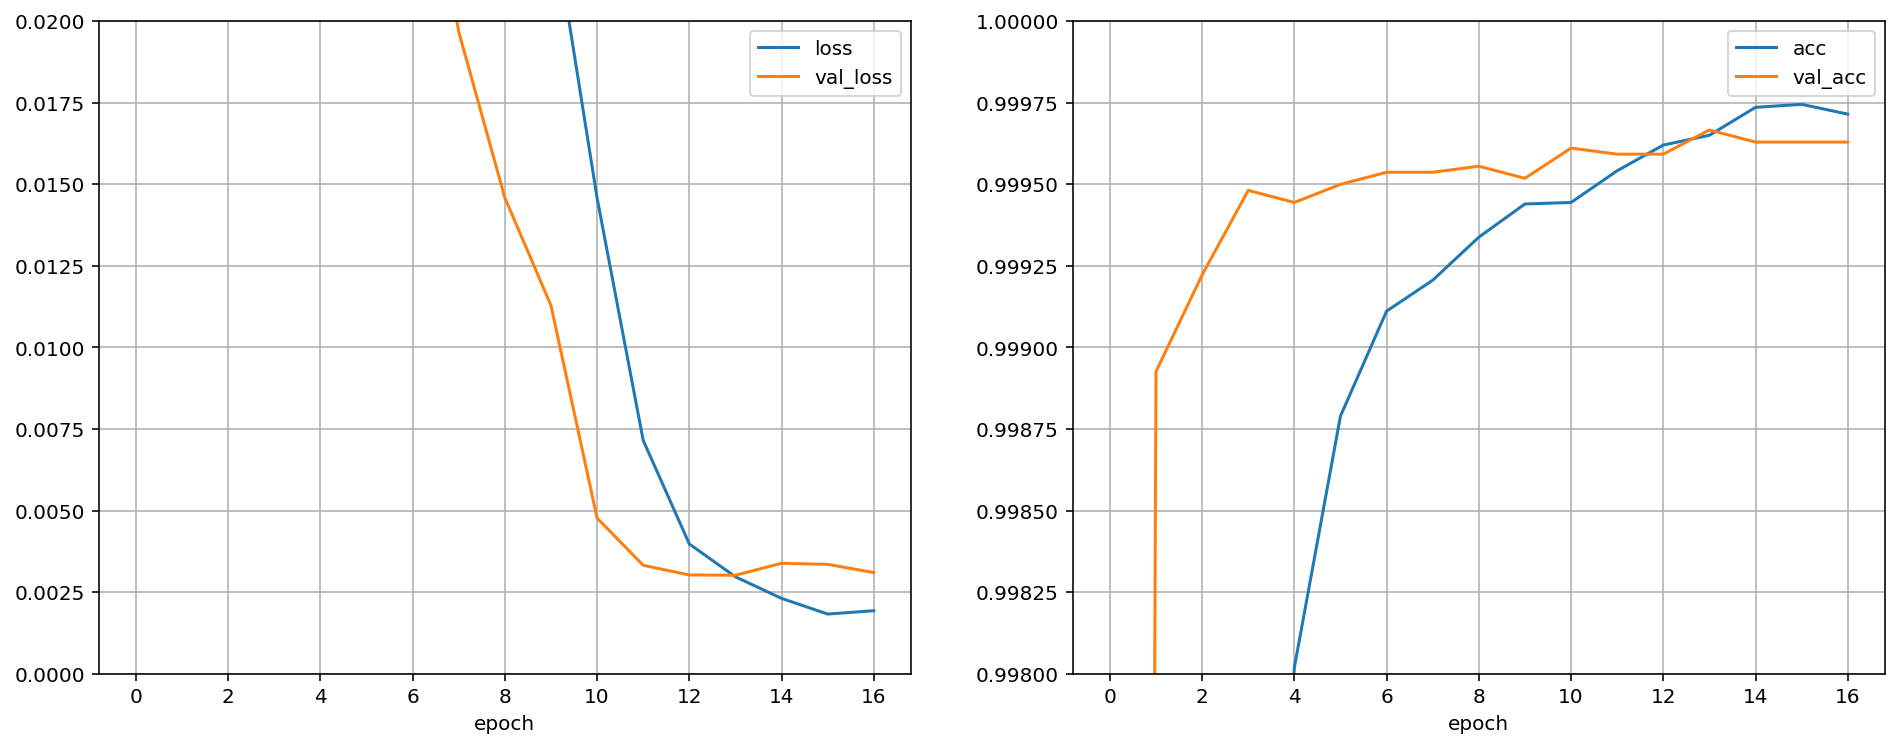

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.02)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(0.998, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [35]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     53474
          1       0.99      0.97      0.98       530

avg / total       1.00      1.00      1.00     54004

[[53471     3]
 [   15   515]]


In [36]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,title,authors,venue,year,id2,title,authors,venue,year
31899,conf/vldb/SrikantA95,mining generalized association rules,srikant agrawal,vldb,1995,kAi6HssDySgJ,fast for mining assoiciation rules,agrawal srikant,the 20th vldb,0.0
24663,conf/sigmod/YerneniLGU99,computing capabilities of mediators,yerneni li ullman,sigmod conference,1999,Gnb52DoKdJwJ,extended version computing capabilities of,yerneni,edu wyerneni pubs,0.0
40247,conf/sigmod/HanFHCC94,dblearn system prototype for knowledge discovery in relational databases,han fu huang cai cercone,sigmod conference,1994,bJLqgUjkbNEJ,advances of the dblearn system for knowledge discovery in large databases,han fu tang,nan,0.0
40241,conf/vldb/HellersteinNP95,generalized search trees for database systems,hellerstein naughton pfeffer,vldb,1995,iLRI5OqO94UJ,avi pfeffer generalized search trees for database systems 1995 21st int,jm hellerstein jf naughton,very large data bases,0.0
51310,conf/sigmod/DogacAEOADAOS94,metu dbms,dogac arpinar evrendilek ozkan altintas durusoy altinel okay saygin,sigmod conference,1994,fsa72WmA67kJ,metu database system,,demo description in the acm sigmod on,0.0


# Save model and histories 

In [37]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-base-2-allcomp-allsim.csv', index=False)
model.save_weights('../data/models/dblp-scholar-base-2-allcomp-allsim')

# Test model 

In [4]:
model.load_weights('../data/models/dblp-scholar-base-2-allcomp-allsim')
y_test_pred = model.predict(X_test, batch_size=8192)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99966   0.99993   0.99979     53467
          1    0.99237   0.96654   0.97928       538

avg / total    0.99959   0.99959   0.99959     54005

[[53463     4]
 [   18   520]]
